In [1]:
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from skimage.filters import frangi, hessian
import skimage.morphology as mp

### Load T2 image

In [2]:
t2 = nib.load('s005_T2w.nii.gz')
t2img = t2.get_fdata()

### Load Tissue Segmentation and Extract BG ROI

In [3]:
seg = nib.load('s005_labels.nii.gz') # infant freesurfer segmentation
seg = seg.get_fdata()
bg = np.zeros_like(seg)
bg[seg==40] = 1
bg[seg==41] = 1
bg[seg==46] = 1
bg[seg==47] = 1
bg = mp.binary_closing(bg, mp.ball(3))

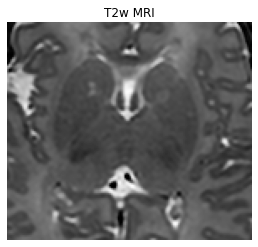

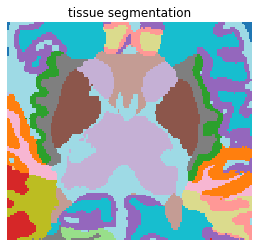

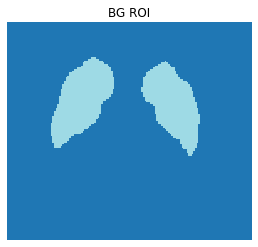

In [4]:
sn = 107
plt.imshow(np.rot90(t2img[72:-72,96:-64,sn]),cmap='gray')
plt.axis('off')
plt.title('T2w MRI')
plt.show()
plt.imshow(np.rot90(seg[72:-72,96:-64,sn]),cmap='tab20',interpolation='nearest')
plt.axis('off')
plt.title('tissue segmentation')
plt.show()
plt.imshow(np.rot90(bg[72:-72,96:-64,sn]),cmap='tab20',interpolation='nearest')
plt.axis('off')
plt.title('BG ROI')
plt.show()

### Apply Frangi Filtering to T2

In [5]:
t2img_f1 = frangi(t2img, scale_range=(1, 2), scale_step=1,black_ridges=False)  

/var/folders/n7/jq4g2jg94p31535vqfnh88b40000gn/T/ipykernel_69913/1136878081.py:1: UserWarning: Use keyword parameter `sigmas` instead of `scale_range` and `scale_range` which will be removed in version 0.17.
  t2img_f1 = frangi(t2img, scale_range=(1, 2), scale_step=1,black_ridges=False)


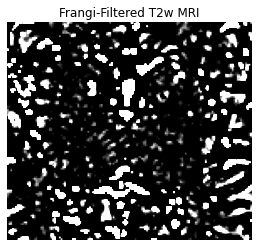

In [6]:
plt.imshow(np.rot90(t2img_f1[72:-72,96:-64,sn]),cmap='gray',vmax=0.00025)
plt.axis('off')
plt.title('Frangi-Filtered T2w MRI')
plt.show()

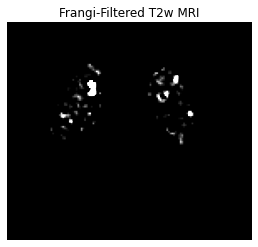

In [7]:
t2img_f1[bg==0]=0
plt.imshow(np.rot90(t2img_f1[72:-72,96:-64,sn]),cmap='gray',vmax=0.00025)
plt.axis('off')
plt.title('Frangi-Filtered T2w MRI')
plt.show()

### Thresholding using BG ROI mean and standard deviation values

In [8]:
bg_mean = np.mean(t2img_f1[bg==1])
bg_std = np.std(t2img_f1[bg==1])
bgpvs = t2img_f1>(bg_mean+1*bg_std)
bgpvs = mp.binary_opening(bgpvs,mp.ball(1))

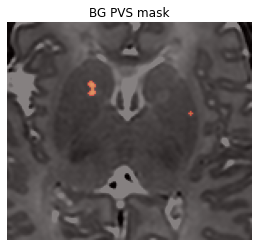

In [9]:
plt.imshow(np.rot90(t2img[72:-72,96:-64,sn]),cmap='gray',vmax=32)
plt.imshow(np.rot90(bgpvs[72:-72,96:-64,sn]),cmap='hot',vmax=2,alpha=0.5)
plt.axis('off')
plt.title('BG PVS mask')
plt.show()

### Calculate BG PVS volume

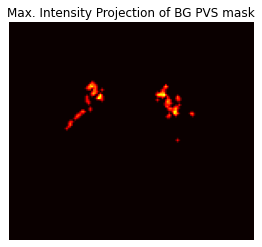

BG PVS volume: 90.375 mm3


In [10]:
plt.imshow(np.rot90(np.sum(bgpvs[72:-72,96:-64,:],axis=2)),cmap='hot',vmax=8)
plt.axis('off')
plt.title('Max. Intensity Projection of BG PVS mask')
plt.show()
bgpvs_vol = np.prod(t2.header['pixdim'][1:4]) * len(bgpvs[bgpvs>0])
print(f'BG PVS volume: {bgpvs_vol} mm3')

### Save BGPVS segmentation

In [11]:
nib.save(nib.Nifti1Image(bgpvs,t2.affine,t2.header),'s005_bgpvs.nii.gz')